# Comprehensive Experiment Data Analysis

##### Note(7/20)
Containing results from three conditioned datesets, with gaussian, median, blackout and destroy-bg ablations. 
Tabled statistics: https://docs.google.com/document/d/1dkbPI0PF8lcrVz4LOKOHBviCjfrji1E6mlKrQdV2fHI/edit?ts=5788e509#


In [26]:
CWD = %pwd
CWD = str(CWD)
import sys
import json
from six.moves import cPickle
import os
import statistics
from collections import defaultdict,Iterable

from IPython.core.display import HTML 
from IPython.core.display import Image, display, display_pretty

import numpy as np
from scipy import misc, polyfit, stats
import matplotlib.pyplot as plt
import PIL
# from PIL import Image
%matplotlib inline  
import random

COCO_PATH = os.path.join(CWD,'data','coco')
COCO_ANNO_PATH = os.path.join(COCO_PATH, 'annotations')
COCO_TEXT_PATH = os.path.join(CWD, 'coco-text')
sys.path.insert(0, COCO_TEXT_PATH)
import coco_text as ct
ct = ct.COCO_Text(os.path.join(COCO_PATH, 'COCO_Text.json'))
import ablation
sys.path.insert(0, os.path.join(CWD, 'coco', 'PythonAPI'))
from pycocotools.coco import COCO,mask

loading annotations into memory...
0:00:03.801685
creating index...
index created!


In [2]:
"""
Load Coco data
"""

# load the data from captions
with open(COCO_ANNO_PATH + '/captions_train2014.json') as f:
    coco_captions = json.load(f)
# print len(coco_captions)
# with open(COCO_ANNO_PATH + 'captions_val2014.json') as f:
#     coco_captions =  dict(coco_captions.items() + json.load(f).items())
# print len(coco_captions)

# build the reverse dictionary, from img_id to captions, img_infos, and annotations
img_captions = {}
for img_info in coco_captions['images']:
    mid = str(img_info['id'])
    if not mid in img_captions:
        img_captions[mid] = {}
    img_captions[mid]['image'] = img_info

for cap_info in coco_captions['annotations']:
    mid = str(cap_info['image_id'])
    if not 'annotation' in img_captions[mid]:
        img_captions[mid]['annotation'] = []
        img_captions[mid]['captions'] = []
    img_captions[mid]['annotation'].append(cap_info)


In [95]:
IN_FILE_NAME  = 'scores_no_rel_texts_blackout.pkl'
OUT_FILE_NAME = 'no_rel_texts_img_ids'
IN_DIR        = 'input'
OUT_DIR       = 'output'

def pre_process_vis(vis, scores, l):
    """Since with large batch size, vis.json might contain duplicates. This function will purge out the duplicates.
    l is the number of image ids used to generate vis. After filtering, vis should have length 2l."""
    surplus = len(vis)-2*l
    return vis[:-surplus], scores[:-(surplus/2)]

def get_stat(data):
    if len(data)==0: return;
    l = len(filter(lambda x:x!=1, data))
    print ""
    print "Total:\t%d;\t\tMean:\t\t%f;\tNone-ones:\t%d(%.02f%%)"%(len(data), statistics.mean(data), l, 100.*l/len(data))
    print "Median:\t%f;\tMedian(H):\t%f;\tMedian(L):\t%f;"%(statistics.median(data), statistics.median_high(data), statistics.median_low(data))
    print "Max:\t%f;\tMin:\t\t%f;\tStd:\t\t%f"%(max(data), min(data),statistics.stdev(data))
    print "\n"
    
def look_up_image(title, img_id, logs, show_original=False):
    print "[%s]%s\n"%(img_id,title)
    print "\tScore:%s;\n"%(logs[img_id]['score'])
    print "\tOriginal Caption:\n\t\t%s;\n\tAblation Caption:\n\t\t%s;"%(logs[img_id]['orig'], logs[img_id]['ablt'])
    if show_original:
        print "\tAnnotated Captions:\n"
        for i, note in enumerate(img_captions[img_id]['annotation']):
            print "\t\t%d. %s\n"%(i+1, str(note['caption']).strip())
    
    ablt_meth = logs['ablation_method'] if 'ablation_method' in logs else 'blackout'
    print logs['ablation_method']
    [(_,orig_img_path , ablt_img_path)]  = ablation.ablate(imgIds = [int(img_id)], mode = ablt_meth, ct=ct, ksize=(7,7),sigma=5.,width=7)
    
    orig_img, ablt_img = misc.imread(orig_img_path), misc.imread(ablt_img_path)
    plt.figure(int(img_id), figsize=(15,30))
    plt.subplot(1,2,1)
    plt.imshow(orig_img)
    plt.subplot(1,2,2)
    plt.imshow(ablt_img)
    plt.show()
    return orig_img, ablt_img

def get_expr_summary(log_file='', in_path=IN_DIR, out_path=OUT_DIR, num=1, pick_one = False):
    logs = cPickle.load(open(os.path.join(CWD, log_file)))
    scores = [(k,x['score']) for k, x in logs.iteritems() if isinstance(x,dict)]
    get_stat(map(lambda x: x[1], scores))

    # sorted_scores_idx = sorted(scores, key=lambda x: x[1])   # sort by score
    # for idx, _ in sorted_scores_idx[:num]:
    #    look_up_image("Images with lowest scores:",idx, logs)

    if pick_one:
        filtered_score = [x for x in scores if x[1] == 0]
        look_up_image("Different images:", filtered_score[random.randint(0,len(filtered_score))][0], logs, show_original=True)
    # sorted(scores, key=lambda x: x[1])   # sort by score
    
    return logs, scores



Total:	15980;		Mean:		0.902979;	None-ones:	2882(18.04%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.227583


[402880]

	Score:0.0;

	Original Caption:
		an airplane is parked on the tarmac at an airport;
	Ablation Caption:
		a view of a city street from a window;
	Annotated Captions:

		1. A very large airplane near some trucks outside.

		2. There is a very large plane here at the airport

		3. Large whir and gold airplane parked at an airport runway.

		4. This Emirates passenger airplane is parked at a terminal.

		5. The airplane is parked on the runway at the airport.

gaussian
Ablating image 1/1


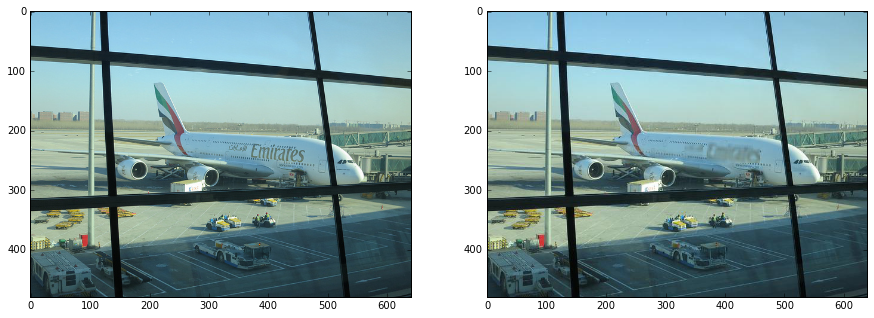

[547378]

	Score:0.0;

	Original Caption:
		a clock on a wall in a room;
	Ablation Caption:
		a woman holding a teddy bear in front of a window;
	Annotated Captions:

		1. Balsa wood lamp. clock and Mickey Mouse cutout

		2. a close up of a cartoon wood cut out

		3. A large clock tower with a giant mickey mouse next to it.

		4. There are some colored lights on a clock tower

		5. Various wooden cut outs of cartoon mouse and buildings with a clock.

gaussian
Ablating image 1/1


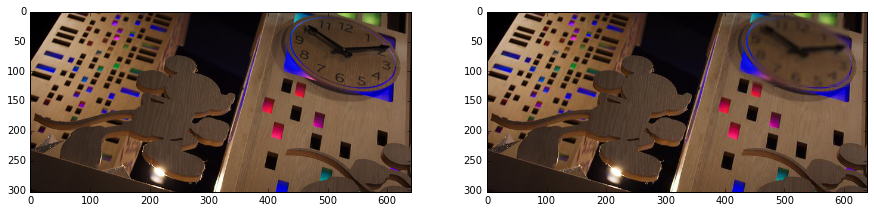

In [79]:
logs, scores = get_expr_summary(log_file=os.path.join("stats","no_rel_text","gaussian.pkl"))
_ = look_up_image("", str(402880), logs, show_original=True)
_ = look_up_image("", str(547378), logs, show_original=True)


Total:	15980;		Mean:		0.809745;	None-ones:	5320(33.29%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.299980


[402880]

	Score:0.777777777778;

	Original Caption:
		an airplane is parked on the tarmac at an airport;
	Ablation Caption:
		an airplane is parked on a runway at an airport;
blackout
Ablating image 1/1


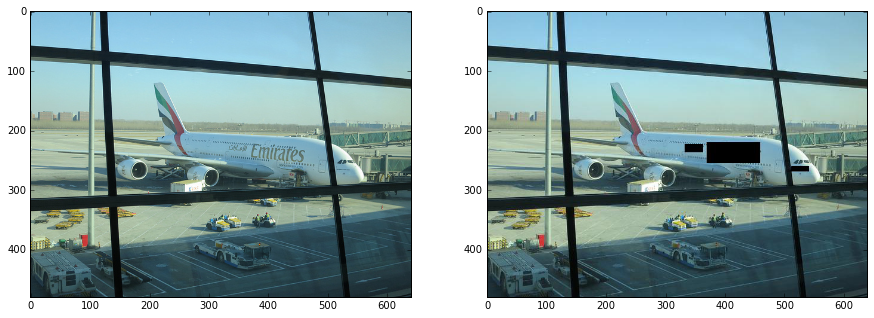

[547378]

	Score:0.125;

	Original Caption:
		a clock on a wall in a room;
	Ablation Caption:
		a person holding a pair of scissors in a room;
blackout
Ablating image 1/1


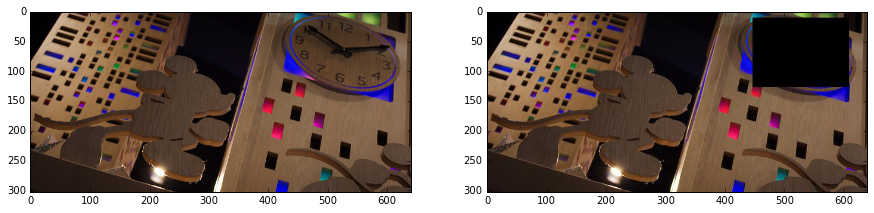

In [80]:
logs, _ = get_expr_summary(log_file=os.path.join("stats","no_rel_text","blackout.pkl"))
_ = look_up_image("", str(402880), logs)
_ = look_up_image("", str(547378), logs)


Total:	15980;		Mean:		0.913922;	None-ones:	2549(15.95%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.216759


[402880]

	Score:1.0;

	Original Caption:
		an airplane is parked on the tarmac at an airport;
	Ablation Caption:
		an airplane is parked on the tarmac at an airport;
median
Ablating image 1/1


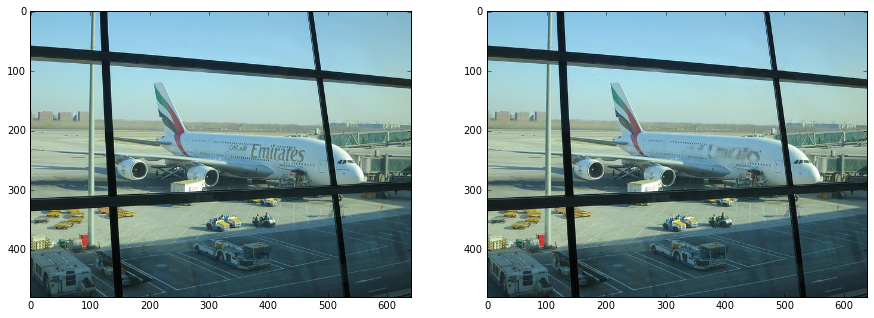

[547378]

	Score:1.0;

	Original Caption:
		a clock on a wall in a room;
	Ablation Caption:
		a clock on a wall in a room;
median
Ablating image 1/1


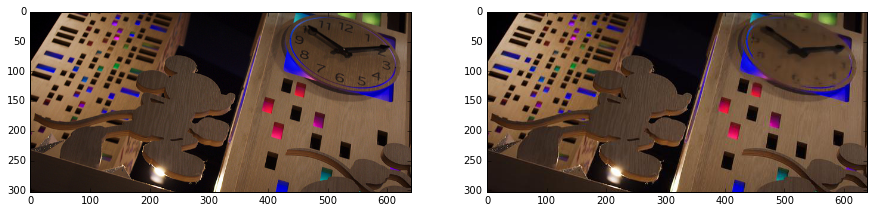

In [81]:
logs, _ = get_expr_summary(log_file=os.path.join("stats","no_rel_text","median.pkl"))

_ = look_up_image("", str(402880), logs)
_ = look_up_image("", str(547378), logs)


Total:	5556;		Mean:		0.829445;	None-ones:	1673(30.11%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.288410


[447432]Gaussian, with relevent text:

	Score:0.0;

	Original Caption:
		a street sign on a pole on a city street;
	Ablation Caption:
		a large building with a clock tower in the background;
	Annotated Captions:

		1. The intersection of Madison Avenue and 42nd street.

		2. Cars drive on the street near many large skyscrapers.

		3. A street sign and a street that has a lot of cars.

		4. Street signs mark the corner of Madison Avenue and 42nd Street.

		5. a street with a lot of tall buidlings on it

gaussian
Ablating image 1/1


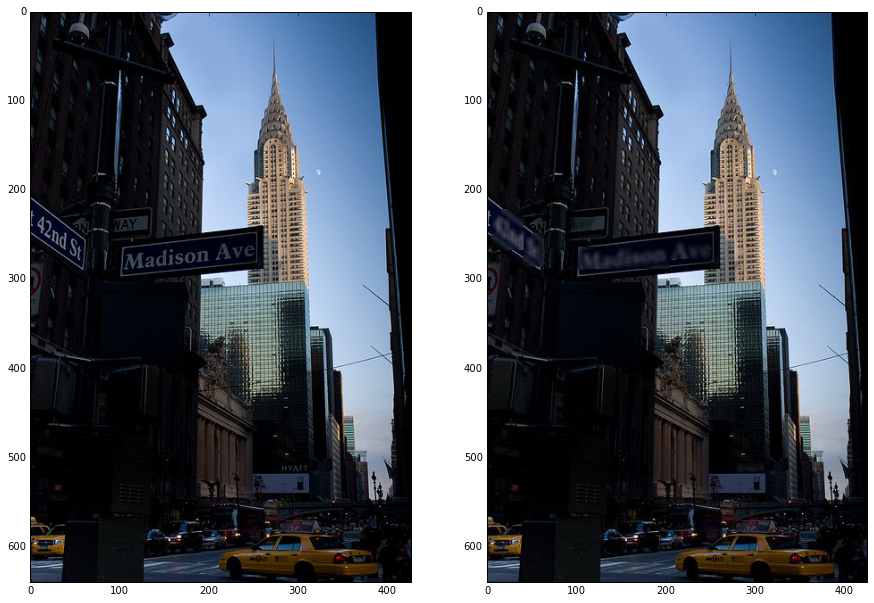

[18873]Gaussian, with relevent text:

	Score:0.0;

	Original Caption:
		a sign that says UNK UNK UNK UNK and UNK;
	Ablation Caption:
		a stuffed bear is sitting on a table;
	Annotated Captions:

		1. A Thomas the tank birthday cake with blue and white frosting.

		2. Blue and white birthday cake with a train engine on it.

		3. A Thomas the Train birthday cake for a toddler boy.

		4. There is a birthday cake for a two year old boy

		5. Thomas the train birthday cake for Samuel's 2nd birthday.

gaussian
Ablating image 1/1


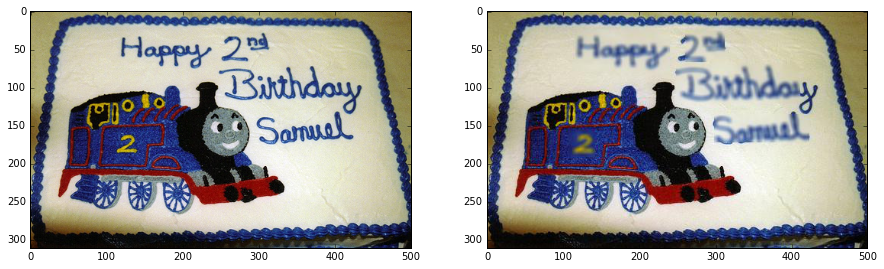

In [89]:
logs, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","gaussian.pkl"))
look_up_image("Gaussian, with relevent text:", str(447432), logs, show_original=True)
look_up_image("Gaussian, with relevent text:", str(18873), logs , show_original=True);


Total:	5556;		Mean:		0.829445;	None-ones:	1673(30.11%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.288410


[447432]Blackout, with relevent text:

	Score:0.0;

	Original Caption:
		a street sign on a pole on a city street;
	Ablation Caption:
		a large building with a clock tower in the background;
blackout
Ablating image 1/1


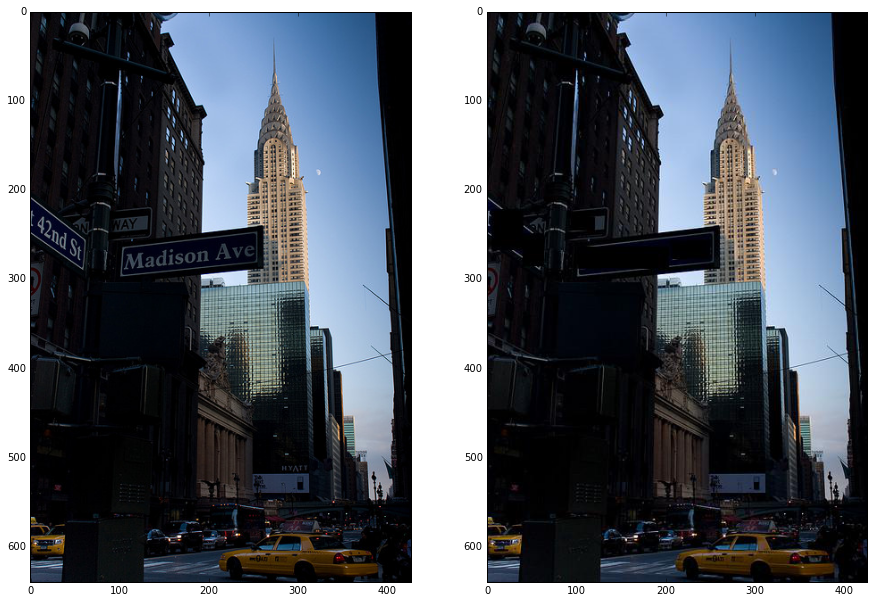

[18873]Blackout, with relevent text:

	Score:0.0;

	Original Caption:
		a sign that says UNK UNK UNK UNK and UNK;
	Ablation Caption:
		a stuffed bear is sitting on a table;
blackout
Ablating image 1/1


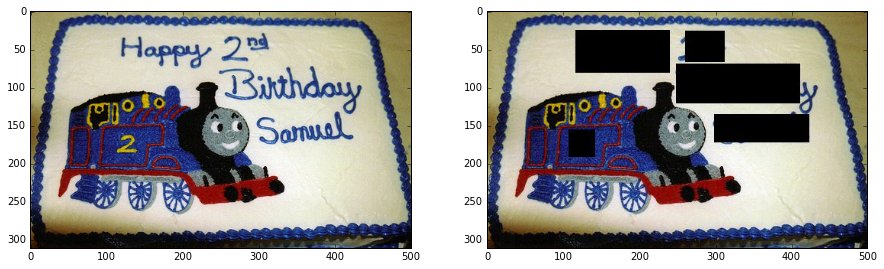

In [90]:
logs, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","blackout.pkl"))
look_up_image("Blackout, with relevent text:", str(447432), logs)
look_up_image("Blackout, with relevent text:", str(18873), logs);


Total:	5556;		Mean:		0.852893;	None-ones:	1475(26.55%)
Median:	1.000000;	Median(H):	1.000000;	Median(L):	1.000000;
Max:	1.000000;	Min:		0.000000;	Std:		0.271832


[447432]Median filter, with relevent text:

	Score:0.1;

	Original Caption:
		a street sign on a pole on a city street;
	Ablation Caption:
		a large building with a large clock on it;
median
Ablating image 1/1


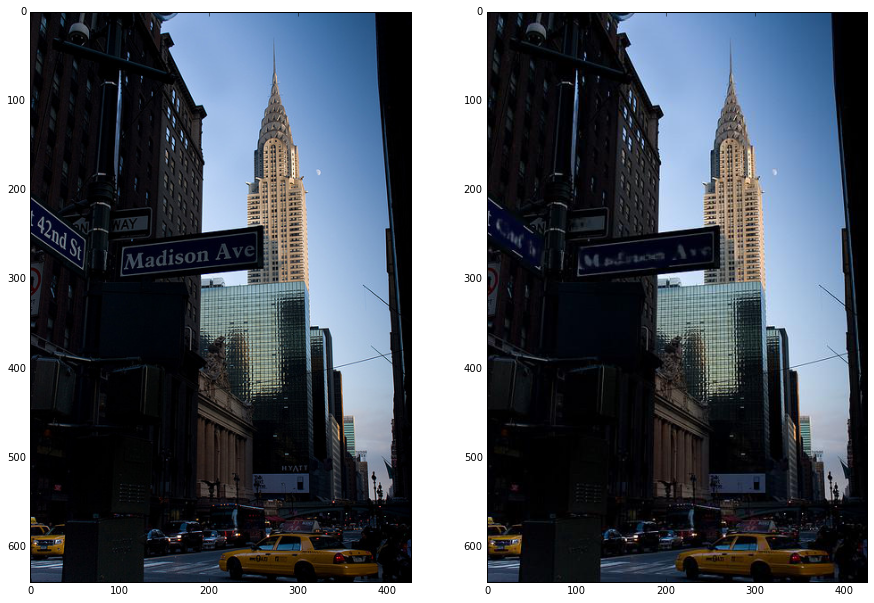

[18873]Median filter, with relevent text:

	Score:0.111111111111;

	Original Caption:
		a sign that says UNK UNK UNK UNK and UNK;
	Ablation Caption:
		a birthday cake with a UNK on it;
median
Ablating image 1/1


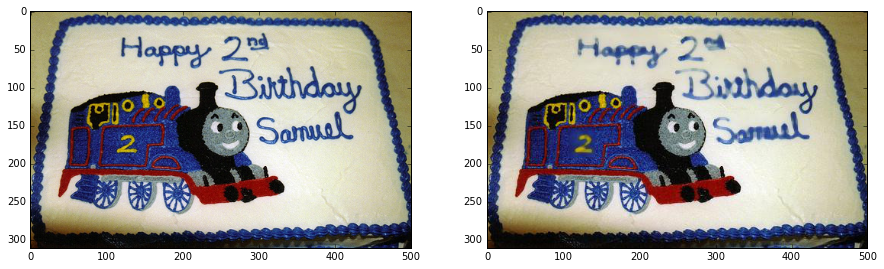

In [96]:
logs, _ = get_expr_summary(log_file=os.path.join("stats","rel_text","median.pkl"))
look_up_image("Median filter, with relevent text:", str(447432), logs)
look_up_image("Median filter, with relevent text:", str(18873), logs);